In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style("whitegrid")

In [3]:
def create_objective(target: float = 0.45):
    def objective(b):
        return (b - target) ** 2
    return objective

<Axes: >

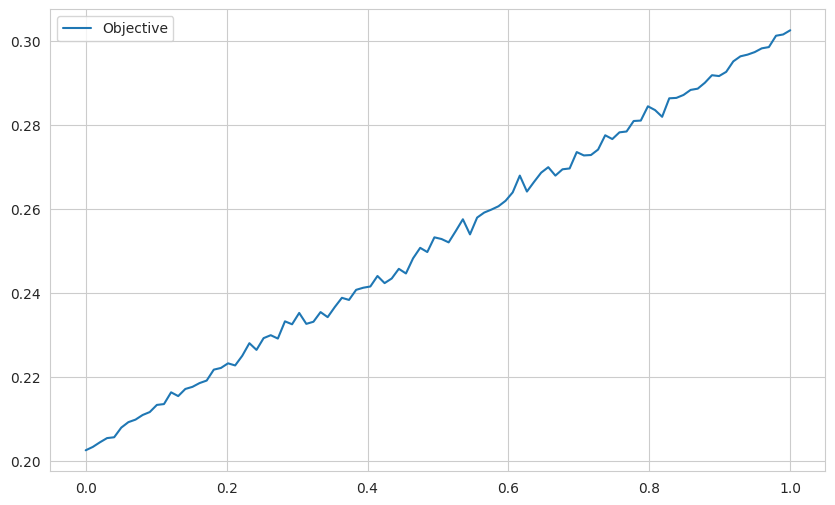

In [4]:
thetas = torch.linspace(0, 1, 100)
evals = 1000
objective = create_objective()

results = []
for theta in thetas:
    theta = torch.tensor([theta] * evals)
    betas = torch.bernoulli(theta)
    results.append(objective(betas).mean().item())

# plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thetas.numpy(), y=results, label="Objective")

In [5]:
def log_pb_bern(b, theta):
    """ Log probability of Bernoulli distribution. """
    return torch.log(theta) * b + torch.log(1 - theta) * (1 - b)

b = torch.tensor([1])
theta = torch.tensor([0.43], requires_grad=True)
log_pb_value = log_pb_bern(b, theta)

autograd.grad(log_pb_value, theta)

(tensor([2.3256]),)

In [41]:
def g(u, theta):
    """ 
    Differentiable reparametrization of z.

    Givem u ~ U(0, 1), and theta from (0, 1).
    Return a sample from p(z). Logistic distribution.
    """
    return torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))


def g_tilde(v, b, theta):
    """
    Differentiable reparametrization of z|b.

    Given v ~ U(0, 1), b ~ Bernoulli(theta).
    and theta from (0, 1).

    Return a sample from the distribution p(z|b).
    """
    zb1 = torch.log((v / (1 - v)) * (1/(1-theta)) + 1)
    zb0 = -torch.log((v / (1 - v)) * (1/theta) + 1)
    return torch.where(b == 1, zb1, zb0)


def H(z):
    """
    The hard threshold function.
    """
    return torch.where(z >= 0, 1, 0)


def sigma(z, lmbda = 1):
    """
    Sigmoid with a temperature parameter.
    """
    return torch.sigmoid(z / lmbda)


def g_lmbda(u, theta, lmbda = 1):
    """
    Differentiable reparametrization of z_lmbda.

    After sigma this makes an alternative to sigma(g(u, theta), lmbda).
    lmbda must be the same for both g_lmbda and sigma.
    """
    quadratic = (lmbda**2 + lmbda + 1)/(lmbda + 1)
    z_lmbda = quadratic * torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))
    return z_lmbda

100%|██████████| 1000/1000 [00:00<00:00, 1478.99it/s]


<Axes: >

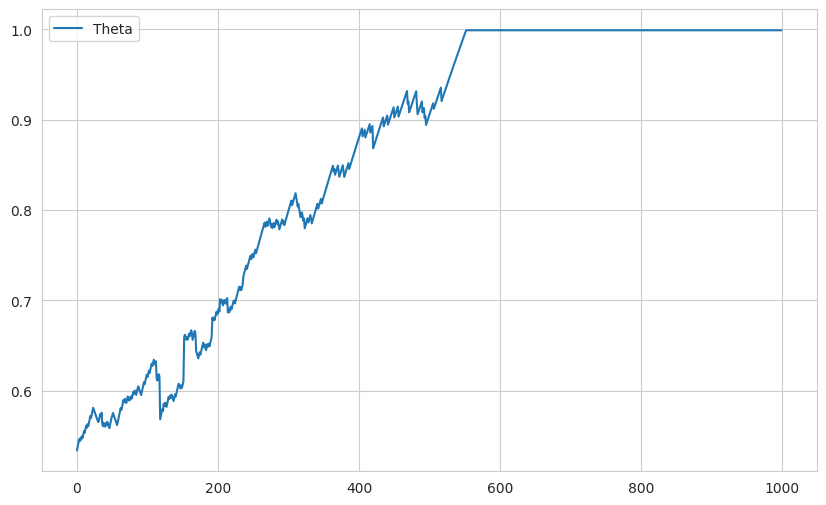

In [50]:
lmbda = 0.01
eta = 0.4
lr = 0.01
max_iter = 1000

n = 1
f = create_objective(target=0.4)
lob_pb = log_pb_bern


thetas = []
estimates = []

theta = torch.tensor([0.53], requires_grad=True)
for _ in tqdm(range(max_iter)):

    estimate = torch.zeros(theta.shape)
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)

        grad_log_pb = autograd.grad(lob_pb(b, theta), theta)[0]
        first_term = ((f(b) - eta * f(sigma(z_tilde, lmbda))) * grad_log_pb).detach()
        second_term = eta * torch.autograd.grad(f(sigma(z, lmbda)), z)[0].detach()
        thrid_term = -eta * torch.autograd.grad(f(sigma(z_tilde, lmbda)), z_tilde)[0].detach()
        estimate += first_term + second_term + thrid_term

    estimate /= n

    if torch.isnan(estimate).any():
        print("NaN detected")
        break

    theta = (lr * estimate + theta).detach() # SGD step
    theta = torch.clamp(theta, 0.001, 0.999)
    thetas.append(theta.item())
    theta.requires_grad = True

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta")
sns.lineplot(x=range(len(estimates)), y=estimates, label="Estimate")